<a href="https://colab.research.google.com/github/femiraj26/Fraud-Detection-System/blob/main/FRAUD_DETECTION_SYSTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install required libraries
!pip install imbalanced-learn

In [ ]:
# Step 2: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE

In [ ]:
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    weights=[0.98, 0.02],  # 2% fraud
    random_state=42
)

print("Original class distribution:", pd.Series(y).value_counts())

Original class distribution: 0    9760
1     240
Name: count, dtype: int64


Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Resampled class distribution:", pd.Series(y_train_res).value_counts())

Resampled class distribution: 0    6832
1    6832
Name: count, dtype: int64


Isolation Forest

In [ ]:
iso = IsolationForest(contamination=0.02, random_state=42)
y_pred_iso = iso.fit_predict(X_test)

# Map -1 to fraud (1), 1 to non-fraud (0)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

print("\nIsolation Forest Report:")
print(classification_report(y_test, y_pred_iso))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_iso))


Isolation Forest Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2928
           1       0.15      0.12      0.14        72

    accuracy                           0.96      3000
   macro avg       0.56      0.55      0.56      3000
weighted avg       0.96      0.96      0.96      3000

ROC-AUC: 0.5537909836065574


Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_res, y_train_res)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))



Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      2928
           1       0.09      0.74      0.15        72

    accuracy                           0.80      3000
   macro avg       0.54      0.77      0.52      3000
weighted avg       0.97      0.80      0.87      3000

ROC-AUC: 0.8391061399514268


ROC CURVE

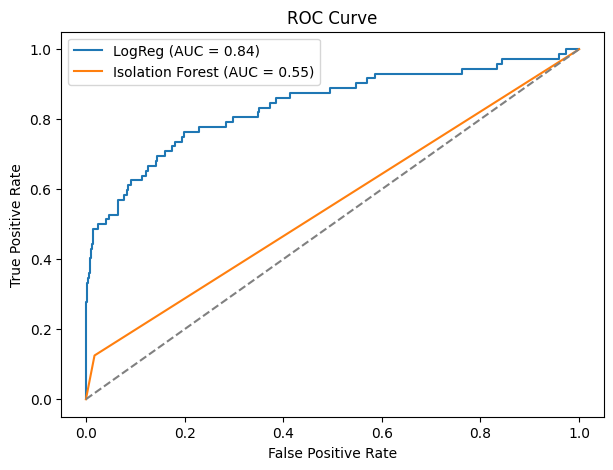

In [ ]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_iso, tpr_iso, _ = roc_curve(y_test, y_pred_iso)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC = {roc_auc_score(y_test, y_proba_lr):.2f})')
plt.plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {roc_auc_score(y_test, y_pred_iso):.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

CONFUSION MATRIX

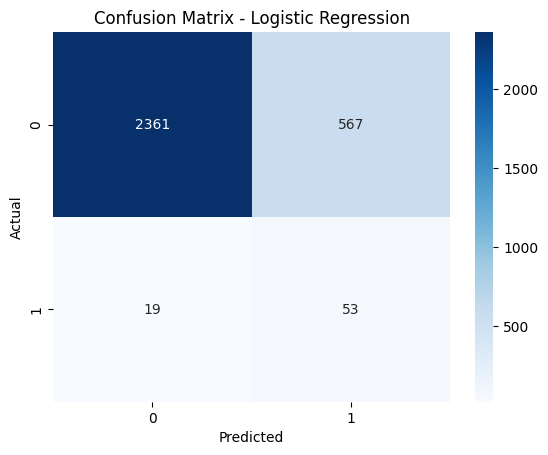

In [ ]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
